In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jaxgym.run import propagate, run_to_component
import jaxgym.components as comp
from jaxgym.stemoverfocus import project_frame_backward, project_frame_forward
from jaxgym.ray import Ray
import os
import tqdm.auto as tqdm
from scipy.ndimage import rotate
from scipy.ndimage import zoom
import json
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".2"



In [2]:
sample_image = plt.imread(r'SilverFast_Resolution_Target_USAF_1951.png')[:, :, 0]
image_shape = sample_image.shape

#remove the black pixel border on the edges
sample_image = sample_image[1:-1, 1:-1]

# Downsample the sample_image by a factor of 2
downsample_factor = 0.5
sample_image = zoom(sample_image, downsample_factor)
sample_image_shape = sample_image.shape

#This is something we can never access in the reverse model, 
# but we can use it to make rotation of an image on the detector possible in the forward model
sample_rotation = 64

sample_image = jnp.array(sample_image, dtype=np.complex64)
sample_px_size = 0.0001
sample_rotated = rotate(sample_image, sample_rotation, reshape=True, cval=1.0)
sample_rotated_edge_length_x = sample_rotated.shape[1] * sample_px_size
sample_rotated_edge_length_y = sample_rotated.shape[0] * sample_px_size

sample_coords_x = jnp.linspace(-sample_rotated_edge_length_x / 2, sample_rotated_edge_length_x / 2, sample_rotated.shape[1])
sample_coords_y = jnp.linspace(-sample_rotated_edge_length_y / 2, sample_rotated_edge_length_y / 2, sample_rotated.shape[0])

sample_interpolant = jax.scipy.interpolate.RegularGridInterpolator(
    (sample_coords_y, sample_coords_x), sample_rotated, fill_value=1.0, bounds_error=False, method='nearest'
)

In [3]:
# Linear Descan Error #1, 1, 0, 0 represents no descan pos or tilt error 

## Descan Error matrix looks like this
# Axx, Ayy, Cxx, Cyy = 4, 3, -5, -4 # Normal Descan Error terms Axx, Ayy, Cxx, Cyy in transfer matrix
# Axy, Ayx, Cxy, Cyx = 6, -7, -3, 5 # Cross Descan Error terms Axy, Ayx, Cxy, Cyx in transfer matrix

## NO Descan ERROR matrix looks like this - 1, 1 because the input position and output position are the same
Axx, Ayy, Cxx, Cyy = 0, 0, 0, 0
Axy, Ayx, Cxy, Cyx = 0, 0, 0, 0

descan_error = [Axx, Axy, Ayx, Ayy, Cxx, Cxy, Cyx, Cyy]

#Set up the parameters for the simulation
semi_conv = 0.05
defocus = 0.01
camera_length = 1.0
scan_shape = (24, 24)
det_shape = (64, 64)
scan_step_yx = (0.0005, 0.0005)
det_px_size= 0.002
scan_rotation = 0

params_dict = {
    'semi_conv': semi_conv,
    'defocus': defocus, # Distance from the crossover to the sample
    'camera_length': camera_length, # Distance from the sample to the detector
    'scan_shape': scan_shape,
    'det_shape': det_shape,
    'scan_step_yx': scan_step_yx,
    'det_px_size': det_px_size,
    'scan_rotation': scan_rotation,
    'descan_error': descan_error
}

#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_step_yx'], scan_shape=params_dict['scan_shape'], scan_rotation=params_dict['scan_rotation'])
Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=0.0, offset_y=0.0)
Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=params_dict['det_shape'], pixel_size=params_dict['det_px_size'], rotation=0.0)
model = [PointSource, ScanGrid, Descanner, Detector]

In [4]:
json.dump(params_dict, open('params.json', 'w'), indent=2)

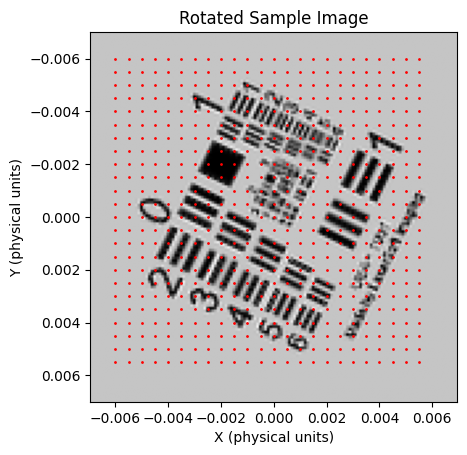

In [5]:
scan_coordinates = ScanGrid.get_coords()

# Set the physical extent (edges) centered around zero
extent = [
    -sample_rotated_edge_length_x/2,
    sample_rotated_edge_length_x/2,
    sample_rotated_edge_length_y/2,
    -sample_rotated_edge_length_y/2,
]

# Reshape the scan coordinates into a 2D grid (centers of pixels).
grid = scan_coordinates.reshape(ScanGrid.scan_shape[0], ScanGrid.scan_shape[1], 2)

plt.figure()
plt.imshow(np.abs(sample_rotated), cmap='gray', extent=extent)
plt.plot(grid[:, :, 1], grid[:, :, 0], 'ro', markersize=1)

plt.title('Rotated Sample Image')
plt.xlabel('X (physical units)')
plt.ylabel('Y (physical units)')
plt.show()

In [7]:
fourdstem_array = np.zeros((*ScanGrid.scan_shape, *Detector.shape), dtype=jnp.complex64)

scan_coords_yx = ScanGrid.coords.reshape(*ScanGrid.scan_shape, 2)


for i in tqdm.trange(fourdstem_array.shape[0]):
    for j in tqdm.trange(fourdstem_array.shape[1], leave=False):
        scan_pos = scan_coords_yx[i, j]
        det_frame = fourdstem_array[i, j]
        fourdstem_array[i, j] = project_frame_forward(model, det_frame, sample_interpolant, scan_pos)


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

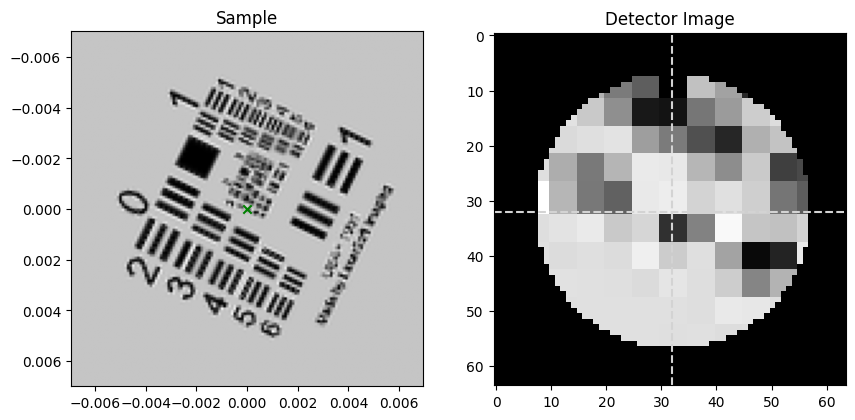

In [ ]:
scan_idx_y, scan_idx_x = 12, 12
scan_pos_y, scan_pos_x = scan_coords_yx[scan_idx_y, scan_idx_x]
det_image_selected = fourdstem_array[scan_idx_y, scan_idx_x]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(np.abs(sample_rotated), extent=extent, cmap='gray')
ax[0].scatter(scan_pos_x, scan_pos_y, c='g', marker='x', alpha=1)
ax[0].set_title('Sample')

ax[1].imshow(np.abs(det_image_selected), cmap='gray')
ax[1].axhline(Detector.shape[0]/2, color='lightgrey', linestyle='--')
ax[1].axvline(Detector.shape[1]/2, color='lightgrey', linestyle='--')
ax[1].set_title('Detector Image')
plt.show()

In [ ]:
np.save('fourdstem_array.npy', fourdstem_array)

In [ ]:
fourdstem_array = np.load('fourdstem_array.npy')
params_dict = json.load(open('params.json'))

semi_conv = params_dict['semi_conv']
defocus = params_dict['defocus']
camera_length = params_dict['camera_length']
scan_shape = params_dict['scan_shape']
det_shape = params_dict['det_shape']
scan_step_yx = params_dict['scan_step_yx']
det_px_size = params_dict['det_px_size']
scan_rotation = params_dict['scan_rotation']
descan_error = params_dict['descan_error']

In [ ]:
# #Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), scan_step=params_dict['scan_step_yx'], scan_shape=params_dict['scan_shape'], scan_rotation=params_dict['scan_rotation'])

scan_coords = ScanGrid.get_coords()
scan_y, scan_x = scan_coords[0, 0], scan_coords[0, 1]

Descanner = comp.Descanner(
    z=jnp.array([params_dict['defocus']]), descan_error=params_dict['descan_error'], offset_x=scan_x, offset_y=scan_y
)

Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), shape=params_dict['det_shape'], pixel_size=params_dict['det_px_size'], rotation=0.0)

model = [PointSource, ScanGrid, Descanner, Detector]

In [ ]:
def run_model_for_jacobians(ray, model):

    model_ray_jacobians = []

    # Get all jacobians from one component to another
    for i in range(1, len(model)):
        distance = (model[i].z - ray.z).squeeze()

        # Get the jacobian of the ray propagation
        # from the previous component to the current component
        propagate_jacobian = jax.jacobian(propagate, argnums=1)(distance, ray)
        model_ray_jacobians.append(propagate_jacobian)
        ray = propagate(distance, ray)

        # Get the jacobian of step function of the current component
        component_jacobian = jax.jacobian(model[i].step)(ray)
        model_ray_jacobians.append(component_jacobian)
        ray = model[i].step(ray)

    # Edit the jacobian matrices to include shifts calculated 
    # from the optical path length derivative - not the best solution for now but it works.
    ABCDs = [] #ABCD matrices at each component

    for ray_jacobian in model_ray_jacobians:
        shift_vector = ray_jacobian.pathlength.matrix # This is the shift vector for each ray, dopl_out/dr_in
        ABCD = ray_jacobian.matrix.matrix # This is the ABCD matrix for each ray, dr_out/dr_in
        ABCD = ABCD.at[:, -1].set(shift_vector[0, :])
        ABCD = ABCD.at[-1, -1].set(1.0)
        ABCDs.append(ABCD)

    return jnp.array(ABCDs)

In [ ]:


# Prepare input ray position for this scan point.
input_ray_positions = jnp.array([scan_x, scan_y, 0.0, 0.0, 1.0])

ray = Ray(
    z=PointSource.z,
    matrix=input_ray_positions,
    amplitude=jnp.ones(1),
    pathlength=jnp.zeros(1),
    wavelength=jnp.ones(1),
    blocked=jnp.zeros(1, dtype=float)
)

transfer_matrices = run_model_for_jacobians(ray, model)

# total_transfer_matrix = transfer_matrices[-1]

# def detector_to_point_source(rays) -> 'Rays':

#     for tm, component in zip(reversed(transfer_matrices[:-1], reversed(model))):
#         if component.has_inverse():
#             rays = rays.inverse(rays)
#         else:
#             rays = jnp.linalg.inv(tm) @ rays
    
#     return rays


total_transfer_matrix = transfer_matrices[-1]

for tm in reversed(transfer_matrices[:-1]):
    total_transfer_matrix = total_transfer_matrix @ tm

detector_to_point_source = jnp.linalg.inv(total_transfer_matrix)

In [ ]:
def loss(det_coords, tilts, inv_matrix, scan_pos):
    n_rays = det_coords.shape[0]
    
    rays_det_matrix = jnp.array([det_coords[:, 1], 
                                det_coords[:, 0],
                                tilts[:, 0],
                                tilts[:, 1],
                                jnp.ones(n_rays)]).T
    
    rays_pt_source = inv_matrix @ rays_det_matrix

    rays_pt_source_x = rays_pt_source[:, 0]
    rays_pt_source_y = rays_pt_source[:, 1]

    start_position = jnp.array([rays_pt_source_x, rays_pt_source_y])   

    error = jnp.linalg.norm(start_position - scan_pos) 

    return error


In [ ]:
det_coords = Detector.get_coords()